In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os,sys
from lgan.diffeomorphism import tf_diffeomorphism
from tqdm import tqdm
from scipy import misc
from keras.preprocessing import image
from scipy import ndimage, misc

Using TensorFlow backend.


In [2]:
#PREROCESS IMAGES - only do once
def resizeFaces():
    path = '/home/dorian/MyGans/LabelGAN/faces_only'
    dirs = os.listdir( path )    
    for item in dirs:
        if os.path.isfile(os.path.join(path,item)):
            inread = ndimage.imread(os.path.join(path,item), mode="RGB")
            image_cut = inread[0:900,200:1100,:] #cut image:1333x1013->900x900
            image_resized = misc.imresize(image_cut, (64, 64))
            misc.imsave('/home/dorian/MyGans/LabelGAN/faces/0/'+item, image_resized)
    
            
def cutImages():
    path = '/home/ben/celeba/data/0'
    dirs = os.listdir( path )    
    for item in dirs:
        if os.path.isfile(os.path.join(path,item)):
            inread = ndimage.imread(os.path.join(path,item), mode="RGB")
            image_cut = inread[40:178,20:158,:] #cut image:218x179->138x138
            image_resized = misc.imresize(image_cut, (64, 64))
            misc.imsave('/home/ben/celeba/cut/0/'+item, image_resized)
            

#resizeFaces()
#cutImages()
print(len(os.listdir("/home/ben/celeba/cut/0")))
print(len(os.listdir('/home/dorian/MyGans/LabelGAN/faces/0/')))

202599
20566


In [3]:
#hyper-parameter
data_size = 202599
batch_size = 32 #batch size
input_dim = 128 #dim http://localhost:8889/notebooks/MyGans/LabelGAN/LabelGAN-celebA.ipynb#x and z input_size
image_size = 4096
imX= 64
imY= 64
LAMBDA = 10
output_dim = imX*imY*3

#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


In [4]:
#simple plot function
def plot(samples, labels,y,x):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(y, x)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.5,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample)   
    return fig


#images plotted while learning
def preprocessPlotImages(samples):
    images = np.zeros((batch_size,imY,imX,3))
    for i in range(batch_size):
        befor = samples[1][i]
        after = samples[0][i]
        befor_reshape = misc.imresize(befor, (20,20))/255
        after[44:64,44:64]=befor_reshape
        images[i]=after
    return images
        
        
        
    

In [5]:
datagen = image.ImageDataGenerator(rescale=1./255)

batcher_celeb = datagen.flow_from_directory(
    directory='/home/ben/celeba/cut',
    target_size= (64, 64),
    color_mode= 'rgb',
    class_mode= None,
    batch_size= batch_size)

batcher_faces = datagen.flow_from_directory(
    directory='/home/dorian/MyGans/LabelGAN/faces',
    target_size= (64, 64),
    color_mode= 'rgb',
    class_mode= None,
    batch_size= batch_size)

Found 202599 images belonging to 1 classes.
Found 20566 images belonging to 1 classes.


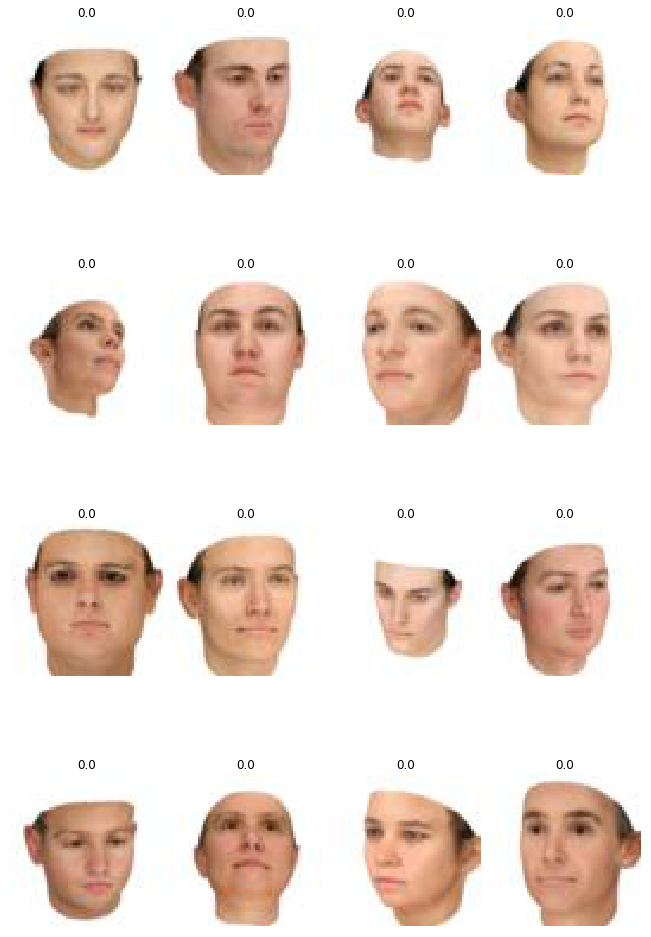

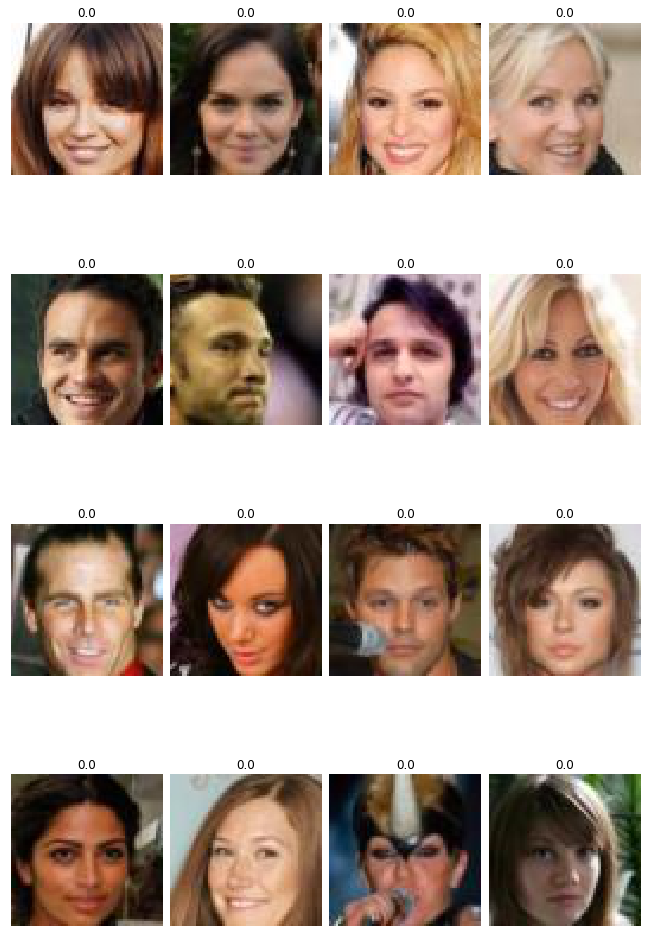

In [6]:
def getImageBatch():
    img_batch = batcher_celeb.next()
    if len(img_batch) != batch_size:
        img_batch = batcher_celeb.next()
    assert len(img_batch) == batch_size
    return img_batch

def getFacesBatch():
    img_batch = batcher_faces.next()
    if len(img_batch) != batch_size:
        img_batch = batcher_faces.next()
    assert len(img_batch) == batch_size
    return img_batch
  
facebatch = getFacesBatch()
plot(facebatch[0:16], np.zeros(16),4,4)
plt.show()
celeb = getImageBatch()
plot(celeb[0:16], np.zeros(16),4,4)
plt.show()

In [7]:
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    for i in range(batch_size):
        vector = np.random.uniform(-1., 1., size=[input_dim]) #create noise vector of 128
        batch[i] = vector
    return batch


In [8]:
def convLayer(layerinput, maps, kernel, stride, act="relu"):
    layerinput = slim.conv2d(layerinput, maps, kernel,stride, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  padding = 'SAME',activation_fn=None)
    if(act == "tanh"):        
        return tf.nn.tanh(layerinput)
    elif(act =="leakyReLU"):
        return leakyReLU(layerinput)
    elif(act =="None"):
        return layerinput
    else:
        #layerinput = slim.batch_norm(layerinput)
        return tf.nn.relu(layerinput) 
    
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def resnet_block(inputs, maps=64, kernel=[3, 3],stride=1):
    layer = slim.conv2d(inputs, maps, kernel, stride,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  padding = 'SAME',activation_fn=None)
    layer = slim.batch_norm(layer)
    layer = tf.nn.relu(layer)
    layer = slim.conv2d(layer, maps, kernel, stride,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  padding = 'SAME',activation_fn=None)
    layer = slim.batch_norm(layer)
    outputs = tf.add(inputs, layer)
    return outputs

In [9]:
#Generator Variables
scalar = tf.Variable(tf.reduce_mean(tf.random_normal([1], stddev=0.01)))
multMatrix = tf.Variable(tf.random_normal([batch_size,2,256], stddev=1))
'''
#Generator - add Detail
def generator_detail(dif_image,noise):
    noise = tf.reshape(noise, (batch_size,64,2))
    noise = tf.matmul(noise, multMatrix) 
    noise = tf.reshape(noise,(batch_size, 32,32,16))
    noise = tf.nn.relu(noise)
    #noise = slim.batch_norm(noise)
    #noise = tf.scalar_mul(scalar, noise)

    details = tf.reshape(dif_image, [batch_size, 64,64,3])
    details = convLayer(details, 16, [3,3],2)

    detail_image = tf.add(details, noise)
    detail_image = convLayer(detail_image, 1024, [9,9],8)
    detail_image = slim.convolution2d_transpose(detail_image,512, [3,3],2)
    #detail_image = slim.batch_norm(detail_image)
    detail_image = tf.nn.relu(detail_image)
    detail_image = convLayer(detail_image, 256, [3,3],1)
    #detail_image = slim.batch_norm(detail_image)    
    detail_image = slim.convolution2d_transpose(detail_image, 128, [3,3],2)
    #detail_image = slim.batch_norm(detail_image)
    detail_image = tf.nn.relu(detail_image)   
    detail_image = slim.convolution2d_transpose(detail_image, 64, [3,3],2)
    #detail_image = slim.batch_norm(detail_image)
    detail_image = tf.nn.relu(detail_image)
    detail_image = slim.convolution2d_transpose(detail_image, 3, [3,3],2) 
    detail_image = tf.nn.tanh(detail_image)

    return detail_image
  
#Generator - predict parameters for Diffeomorphism
def generator_dif_paras(noise_vector):
    with tf.variable_scope('generator_diffeo'):
        params = tf.reshape(noise_vector,[batch_size,8,8,2])
        params = convLayer(params, 16, [3, 3],2)  
        params = convLayer(params, 32, [3, 3],1)
        params = convLayer(params, 2, [3, 3],1,act="tanh")

        params= tf.reshape(params, [batch_size,4,4,2]) 
        return params
 '''   
def simGenerator(image, noise):
    image = tf.reshape(image,[batch_size,imY,imX,3])
    noise = slim.fully_connected(noise, 4096,weights_initializer=tf.truncated_normal_initializer(stddev=0.01))
    noise = tf.reshape(noise, [batch_size,imY,imX,1])
    net = tf.concat([image, noise],3)
    net = slim.conv2d(net, 64, [3,3],1)
    net = resnet_block(net, maps=64, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=64, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=64, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=64, kernel=[3, 3],stride=1)
    net = resnet_block(net, maps=64, kernel=[3, 3],stride=1)
    #net = convLayer(net, 32,[3,3],1)
    net = slim.conv2d(net, 3, [1,1],1)
    return tf.nn.tanh(net)

#Main Generator
def generator(face_image, z):
    with tf.variable_scope('generator'):
        face_image = tf.reshape(face_image,[batch_size, imY,imX,3])
        #dif_params = generator_dif_paras(z)
        #dif_image = tf_diffeomorphism(face_image,dif_params)
        detailed_image = simGenerator(face_image,z)
        return [detailed_image,face_image]



In [10]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[batch_size,imY,imX,3])
        net = slim.conv2d(x, 16, [4, 4],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(x, 32, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 128, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 256, [3, 3],1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 512, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)
        net = leakyReLU(net)
        net = slim.conv2d(net, 1024, [3,3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None) 
        net = leakyReLU(net)
        net = slim.conv2d(net, 1, [2,2],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                         padding = 'SAME',activation_fn=None)       
        return net

In [11]:
def predictStartImage(genImage):
    with tf.variable_scope('predictor'):
        genImage = slim.conv2d(genImage,64, [3,3],2,activation_fn=None)
        genImage = slim.batch_norm(genImage)
        genImage = tf.nn.relu(genImage)
        genImage = slim.conv2d(genImage, 128, [3,3],2,activation_fn=None)
        genImage = slim.batch_norm(genImage)
        genImage = tf.nn.relu(genImage)
        genImage = slim.convolution2d_transpose(genImage,64, [3,3],2,activation_fn=None)
        genImage = slim.batch_norm(genImage)
        genImage = tf.nn.relu(genImage)
        genImage = slim.convolution2d_transpose(genImage,3, [3,3],2)
        return tf.nn.tanh(genImage)    

In [12]:
#input
Face = tf.placeholder(tf.float32, shape=[batch_size, imY,imX,3])
X = tf.placeholder(tf.float32, shape=[batch_size,imY,imX,3])
Z = tf.placeholder(tf.float32, shape=[batch_size, input_dim])


#Models
face_images = generator(Face, Z ) 
D_real = discriminator(X)
D_fake = discriminator(face_images[0])
predictImage = predictStartImage(face_images[0])

#variables V1
theta_D = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
theta_Pred = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'predictor')


D_losses, G_losses = [],[]

#meanSquaredErrorLoss for Predictor:
P_loss = tf.reduce_mean(tf.squared_difference(predictImage, Face))

#Discriminator Wasserstein-Loss
D_loss = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real)

#Generator L1-Loss
G_l1_loss = tf.reduce_sum(tf.abs(face_images[0]-face_images[1]))

#Generator Loss
G_loss = -tf.reduce_mean(D_fake)+tf.multiply(500.0,P_loss)


#improved WGAN without weight clipping. Instead penalizing gradient 
alpha = tf.random_uniform(shape=[batch_size,1], minval=0.,maxval=1.)

differences = tf.reshape(face_images[0] - X, (batch_size, output_dim))
interpolates = tf.reshape(X,(batch_size, output_dim)) + (alpha*differences)
interpolates = tf.reshape(interpolates, (batch_size, 64,64,3))
gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
D_loss += LAMBDA*gradient_penalty

G_losses.append(G_loss)
D_losses.append(D_loss)

G_loss = tf.add_n(G_losses)
D_loss = tf.add_n(D_losses) 

#Solver
D_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(D_loss, var_list=theta_D, colocate_gradients_with_ops=True))
G_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(G_loss, var_list=theta_G, colocate_gradients_with_ops=True))
G_solver_L1 = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(G_l1_loss, var_list=theta_G, colocate_gradients_with_ops=True))
P_solver = (tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5, beta2=0.9)
            .minimize(P_loss, var_list=theta_Pred, colocate_gradients_with_ops=True))



if not os.path.exists('out-celebA-faces/'):
    os.makedirs('out-celebA-faces/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

In [13]:
#pretrain gen with L1 Loss:
for t in tqdm(range(50)): 
    faces = getFacesBatch()
    z = sample_z(batch_size)
    _, G_loss_curr = sess.run(
        [G_solver_L1, G_loss],
        feed_dict={Face:faces,Z:z}
    )


100%|██████████| 50/50 [00:12<00:00,  4.36it/s]


In [14]:
#pretrain disc:
for t in tqdm(range(500)):
    #train discriminator
    Xdata = getImageBatch()
    faces = getFacesBatch()
    z = sample_z(batch_size)
    _, D_loss_curr = sess.run(
        [D_solver, D_loss],
        feed_dict={X: Xdata, Face:faces,Z:z}
    ) 

100%|██████████| 500/500 [01:32<00:00,  5.42it/s]


In [ ]:
#pretrain predictor
for t in tqdm(range(100)):
    faces = getFacesBatch()
    z = sample_z(batch_size)
    _, D_loss_curr = sess.run(
        [P_solver, P_loss],
        feed_dict={Face:faces,Z:z}
    ) 

100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


Iter: 0; D loss: 0.1794; G_loss: 2.448e+03


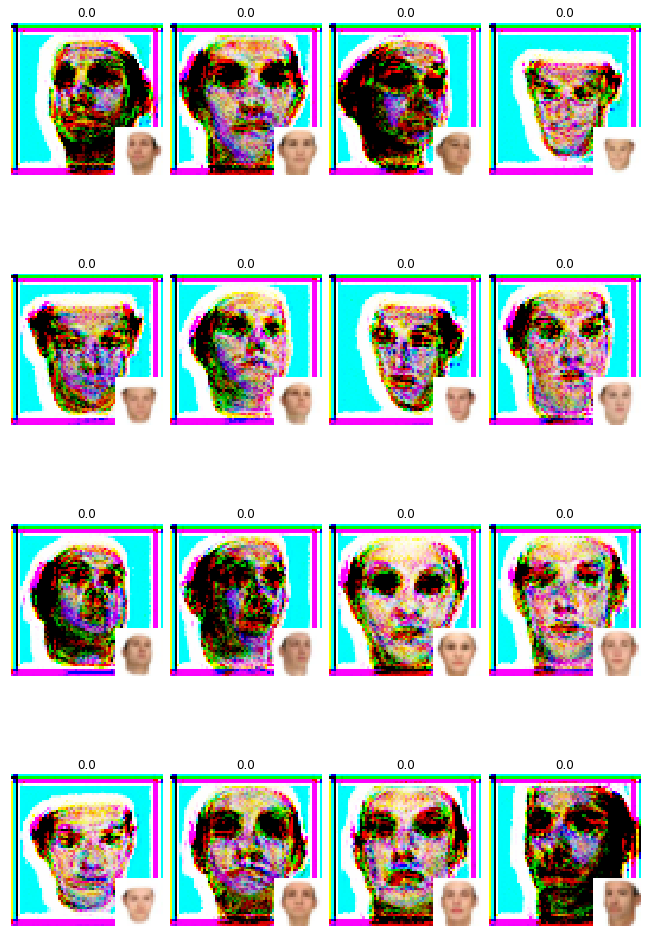

Iter: 100; D loss: 0.09775; G_loss: 403.0


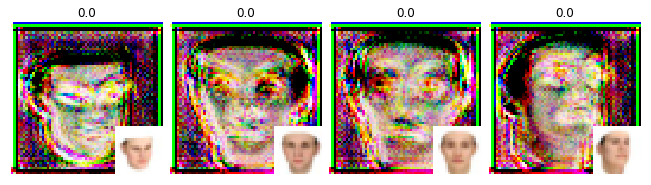

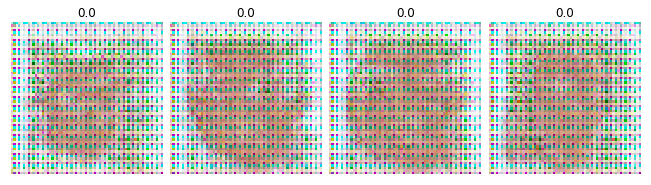

Iter: 200; D loss: 0.03965; G_loss: 449.8


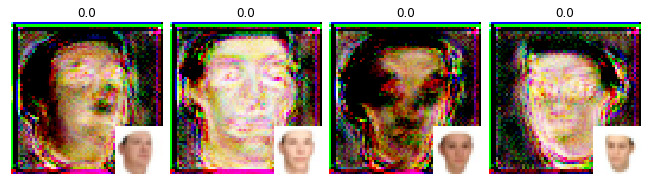

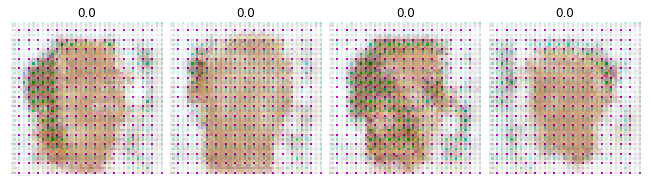

Iter: 300; D loss: 0.02016; G_loss: 441.0


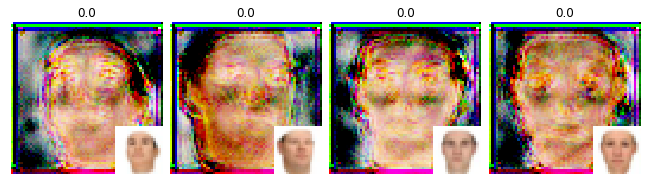

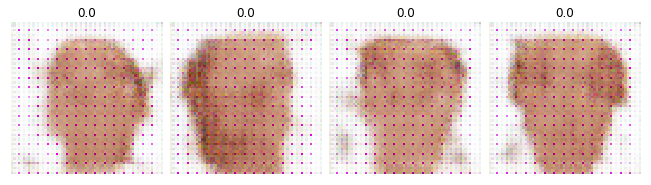

Iter: 400; D loss: 0.01062; G_loss: 245.2


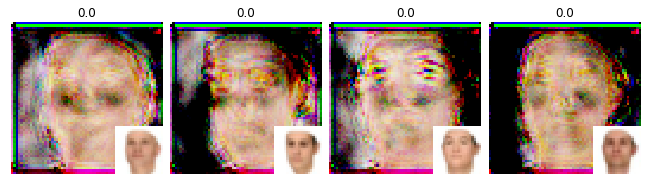

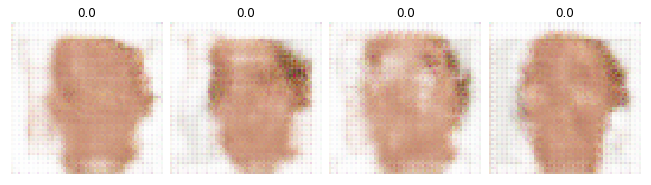

Iter: 500; D loss: 0.008502; G_loss: 169.1


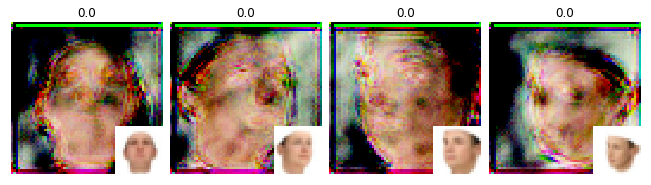

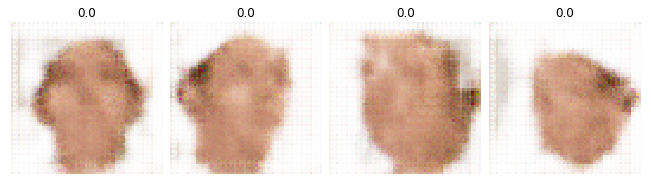

Iter: 600; D loss: 0.008297; G_loss: 45.04


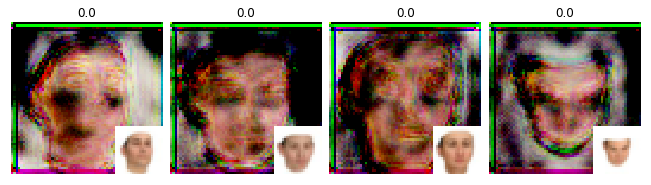

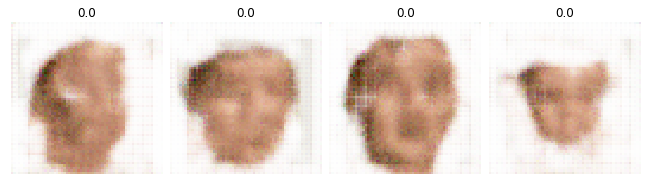

Iter: 700; D loss: 0.007306; G_loss: 36.72


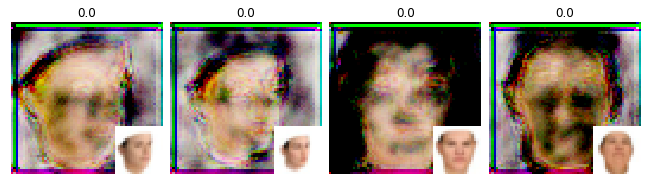

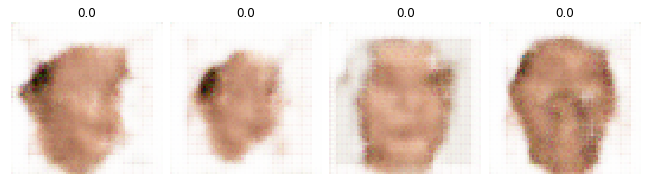

Iter: 800; D loss: 0.00733; G_loss: 58.22


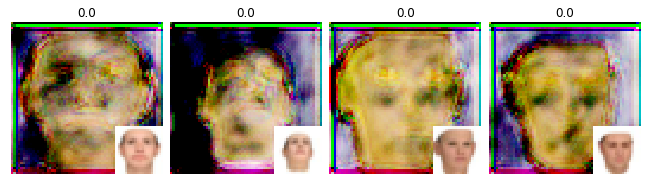

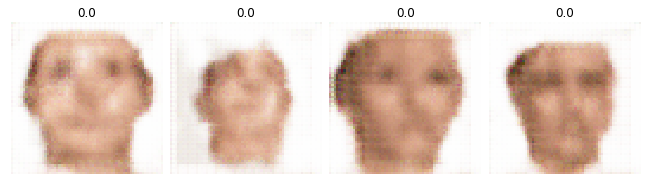

Iter: 900; D loss: 0.03059; G_loss: 42.82


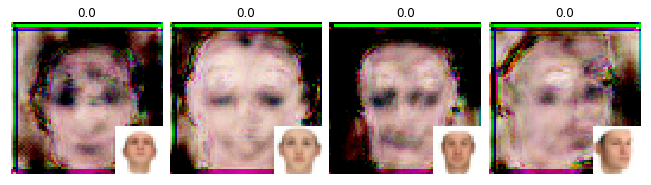

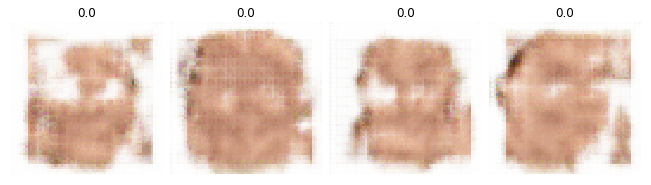

Iter: 1000; D loss: 0.005849; G_loss: 88.92


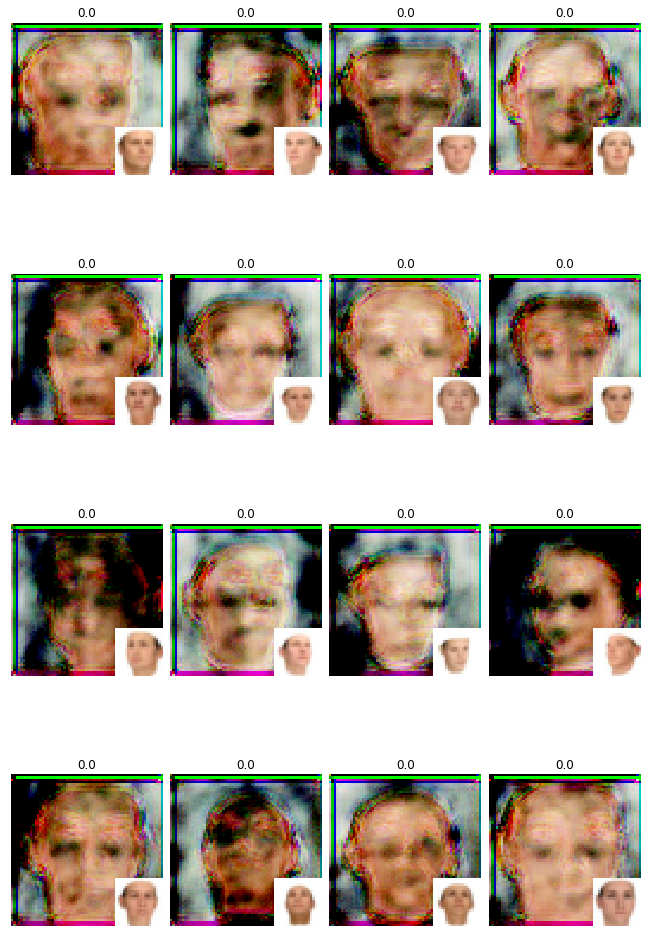

Iter: 1100; D loss: 0.005814; G_loss: 35.59


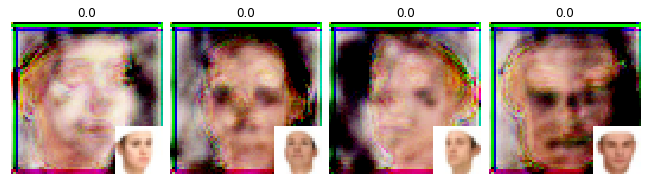

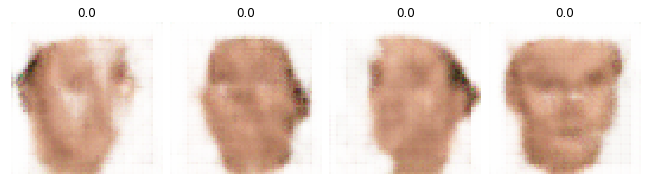

Iter: 1200; D loss: 0.004802; G_loss: 99.41


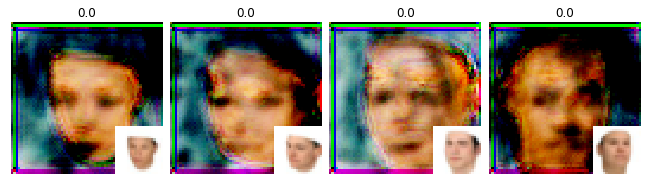

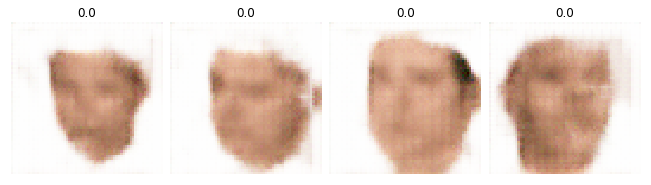

Iter: 1300; D loss: 0.005336; G_loss: 30.47


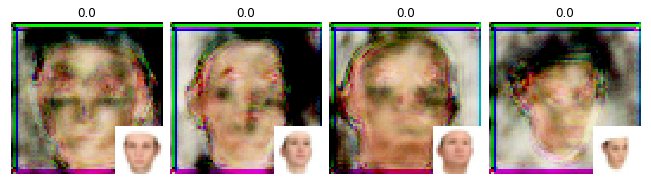

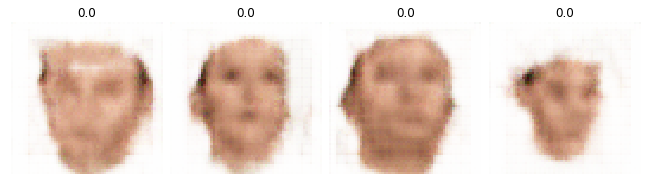

Iter: 1400; D loss: 0.004473; G_loss: 79.4


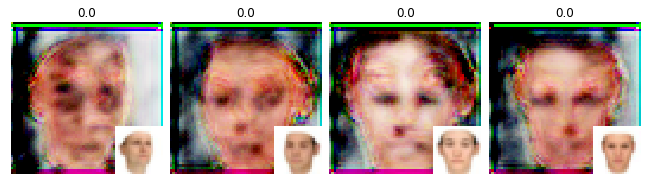

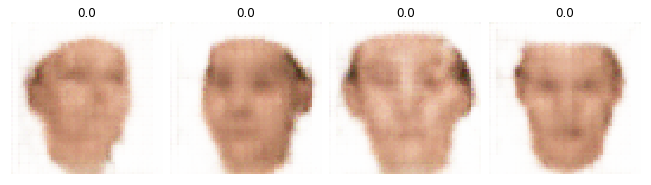

Iter: 1500; D loss: 0.00421; G_loss: 47.41


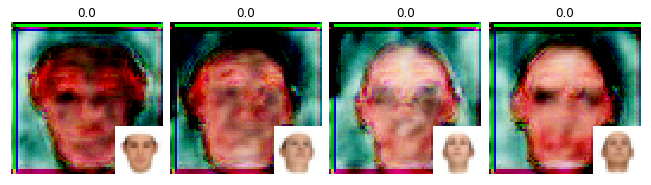

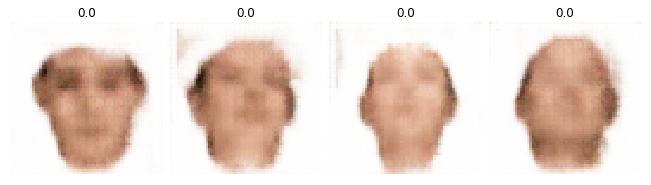

Iter: 1600; D loss: 0.006668; G_loss: 33.71


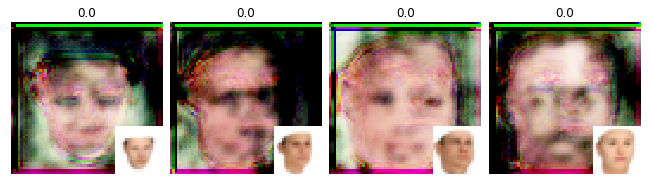

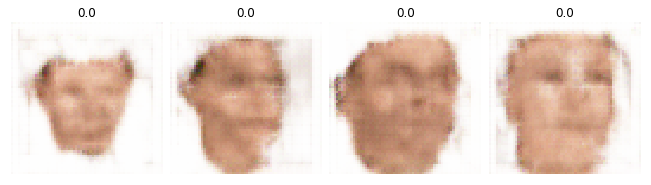

Iter: 1700; D loss: 0.004512; G_loss: 28.87


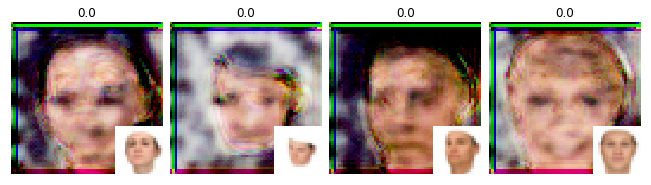

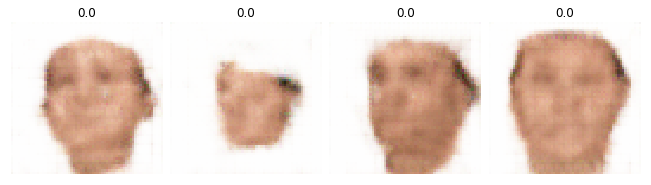

Iter: 1800; D loss: 0.01163; G_loss: -15.74


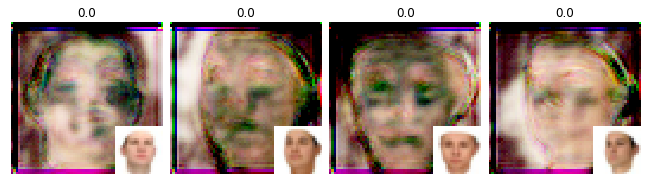

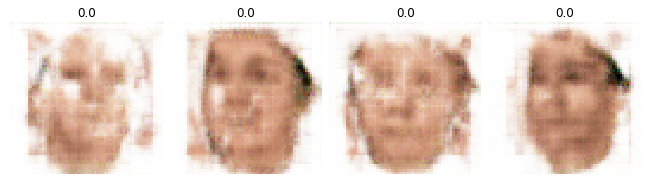

In [ ]:
i = 0
d_costs = []
g_costs = []
for it in range(100000):
    for q in range(5): #train discriminator
        Xdata = getImageBatch()
        faces = getFacesBatch()
        z = sample_z(batch_size)
        _, D_loss_curr = sess.run(
            [D_solver, D_loss],
            feed_dict={X: Xdata,Face:faces,Z:z}
        )
        d_costs.append(D_loss_curr)
    #trainGenerator 
    faces = getFacesBatch()
    z = sample_z(batch_size)
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={Face:faces,Z:z}
    )
    g_costs.append(G_loss_curr)
    #trainPredictor
    faces = getFacesBatch()
    z = sample_z(batch_size)
    _, D_loss_curr = sess.run(
        [P_solver, P_loss],
        feed_dict={Face:faces,Z:z}
    ) 
    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        if it % 1000 == 0:
            faces = getFacesBatch()
            z = sample_z(batch_size)
            samples = sess.run(face_images, feed_dict={Face:faces,Z:z})  
            imagesToPlot = preprocessPlotImages(samples)

            fig = plot(imagesToPlot[:16],np.zeros(16),4,4)
            plt.savefig('out-celebA-faces/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
        else:
            faces = getFacesBatch()
            z = sample_z(batch_size)
            samples = sess.run(face_images, feed_dict={Face:faces,Z:z})   
            imagesToPlot = preprocessPlotImages(samples)
            
            baseImages = sess.run(predictImage, feed_dict={Face:faces,Z:z})
            
            fig = plot(imagesToPlot[:4],np.zeros(4),1,4)
            plt.show()
            fig2 = plot(baseImages[:4],np.zeros(4),1,4)
            plt.show()
            
plt.close(fig)